In [1]:
import sys
sys.path.append('..')
from pymavlink import mavutil
import matplotlib.pyplot as plt
import pandas as pd
import os
import geopandas as gpd
from shapely.geometry import Point, LineString

from sqlalchemy import create_engine

from config import RUTA_UNIDAD_ONE_DRIVE
from config import RUTA_LOCAL_ONE_DRIVE
from config import POSTGRES_UTEA

RUTA_COMPLETA = os.path.join(RUTA_UNIDAD_ONE_DRIVE, RUTA_LOCAL_ONE_DRIVE)

def obtener_engine():
    return create_engine(
        f"postgresql+psycopg2://{POSTGRES_UTEA['USER']}:{POSTGRES_UTEA['PASSWORD']}@{POSTGRES_UTEA['HOST']}:{POSTGRES_UTEA['PORT']}/{POSTGRES_UTEA['DATABASE']}"
    )

In [22]:
vehiculo = 'DA02'

In [23]:
if vehiculo == 'DA01':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_01'
elif vehiculo == 'DA02':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_02'
elif vehiculo == 'DA03':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_03'
contenido = os.listdir(path_log)
len(contenido)

126

In [24]:
gdf_rec = gpd.read_postgis(
    "SELECT * FROM drones_control_bio.recorridos_lib", 
    obtener_engine(), 
    geom_col='geom'  # columna con la geometría
)

In [25]:
gdf_rec.head()

,id,geom,idd,nombre,vehiculo,num_vert,asignado
0,1,"MULTILINESTRING ((471873.745 8084797.248, 4718...",-1,2025-05-02 08-32-28.tlog,DA02,2517.0,ORIGINAL
1,2,"MULTILINESTRING ((478886.299 8093597.535, 4788...",-1,2025-05-05 16-16-47.tlog,DA02,1056.0,ORIGINAL
2,247,"MULTILINESTRING ((474276.861 8075803.608, 4742...",616,2025-08-12 03-00-11.tlog,DA02,1710.0,None
3,248,"MULTILINESTRING ((473445.600 8076788.235, 4734...",616,2025-08-12 03-45-43.tlog,DA02,1605.0,None
4,249,"MULTILINESTRING ((469649.803 8090516.827, 4696...",617,2025-08-12 04-25-58.tlog,DA02,1988.0,None


In [26]:
# Filtrar la lista 'contenido' para excluir elementos que están en la columna 'nombre' del GeoDataFrame
contenido_filtrado = [item for item in contenido if item not in gdf_rec['nombre'].values]
len(contenido_filtrado)

6

In [27]:
contenido_filtrado

['2025-09-11 08-44-22.tlog',
 '2025-09-12 14-07-43.tlog',
 '2025-09-18 16-50-36.tlog',
 '2025-09-23 22-42-58.tlog',
 '2025-09-24 00-04-38.tlog',
 '2025-09-25 09-56-36.tlog']

In [28]:
def leer_logs(lista_logs):
    list_geo = []
    list_name = []
    for i in lista_logs:
        log = path_log + '/' + i
        
        name = i
        
        mlog = mavutil.mavlink_connection(log)
        lats = []
        lons = []
        while True:
            msg = mlog.recv_match()
            if not msg:
                break
            # Ejemplo de procesamiento de mensaje
            if msg.get_type() == 'GLOBAL_POSITION_INT':
                lat = msg.lat / 1e7  # Latitud en grados
                lon = msg.lon / 1e7  # Longitud en grados
                lats.append(lat)
                lons.append(lon)

        coors = {'lat':lats, 'lon':lons}
        df = pd.DataFrame(coors)
        
        geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
        line = LineString(geometry)
        list_geo.append(line)
        list_name.append(name)
    return (list_geo, list_name)

In [29]:
lineas, names = leer_logs(contenido_filtrado)
lineas

[<LINESTRING (0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0...>,
 <LINESTRING (0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0...>,
 <LINESTRING (0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0...>,
 <LINESTRING (-63.004 -17.042, -63.004 -17.042, -63.004 -17.042, -63.004 -17....>,
 <LINESTRING (-62.966 -17.197, -62.966 -17.197, -62.966 -17.197, -62.966 -17....>,
 <LINESTRING (-62.983 -17.195, -62.983 -17.195, -62.983 -17.195, -62.983 -17....>]

In [30]:
# Crear un GeoDataFrame con los LineStrings y sus nombres
gdf_lines = gpd.GeoDataFrame({'nombre': names, 'geometry': lineas}, crs="EPSG:4326")
gdf_lines.head(3)

,nombre,geometry
0,2025-09-11 08-44-22.tlog,"LINESTRING (0.00000 0.00000, 0.00000 0.00000, ..."
1,2025-09-12 14-07-43.tlog,"LINESTRING (0.00000 0.00000, 0.00000 0.00000, ..."
2,2025-09-18 16-50-36.tlog,"LINESTRING (0.00000 0.00000, 0.00000 0.00000, ..."


In [31]:
# Función para contar la cantidad de coordenadas en una geometría de tipo LINESTRING
def contar_coordenadas(linea):
    return len(linea.coords)

# Función para dividir y limpiar las líneas
def dividir_y_limpiar_linea(linea):
    puntos = list(linea.coords)
    nuevas_lineas = []
    nueva_linea = []
    
    for punto in puntos:
        if punto != (0, 0):
            nueva_linea.append(punto)
        else:
            if nueva_linea:
                nuevas_lineas.append(LineString(nueva_linea))
                nueva_linea = []
    
    if nueva_linea:
        nuevas_lineas.append(LineString(nueva_linea))
    
    return nuevas_lineas

In [32]:
# Crear una lista para las nuevas líneas y nombres
nuevas_lineas = []
nuevos_nombres = []
for idx, row in gdf_lines.iterrows():
    lineas_divididas = dividir_y_limpiar_linea(row.geometry)
    for linea in lineas_divididas:
        nuevas_lineas.append(linea)
        nuevos_nombres.append(row['nombre'])

In [33]:
# Crear un nuevo GeoDataFrame con las nuevas líneas
gdf_lines = gpd.GeoDataFrame({'nombre': nuevos_nombres, 'geometry': nuevas_lineas}, crs="EPSG:4326")

In [34]:
gdf_lines['num_vert'] = gdf_lines['geometry'].apply(contar_coordenadas)
gdf_lines['vehiculo'] = vehiculo
gdf_lines.head(3)

,nombre,geometry,num_vert,vehiculo
0,2025-09-23 22-42-58.tlog,"LINESTRING (-63.00365 -17.04204, -63.00365 -17...",5888,DA02
1,2025-09-24 00-04-38.tlog,"LINESTRING (-62.96576 -17.19688, -62.96576 -17...",4351,DA02
2,2025-09-25 09-56-36.tlog,"LINESTRING (-62.98282 -17.19461, -62.98282 -17...",2587,DA02


<Axes: >

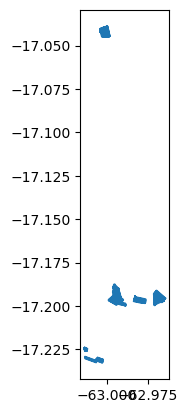

In [35]:
gdf_lines.plot()

In [36]:
gdf_lines.crs = "EPSG:4326"
gdf_lines_utm = gdf_lines.to_crs(epsg=32720)

<Axes: >

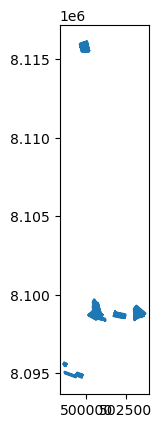

In [37]:
gdf_lines_utm.plot()

In [38]:
gdf_lines_utm['idd'] = 0
gdf_lines_utm = gdf_lines_utm.rename_geometry("geom")

In [39]:
gdf_lines_utm

,nombre,geom,num_vert,vehiculo,idd
0,2025-09-23 22-42-58.tlog,"LINESTRING (499611.984 8115794.631, 499611.984...",5888,DA02,0
1,2025-09-24 00-04-38.tlog,"LINESTRING (503640.779 8098664.827, 503640.779...",4351,DA02,0
2,2025-09-25 09-56-36.tlog,"LINESTRING (501827.297 8098915.815, 501827.307...",2587,DA02,0
3,2025-09-25 09-56-36.tlog,"LINESTRING (500790.897 8098767.198, 500790.940...",3592,DA02,0
4,2025-09-25 09-56-36.tlog,"LINESTRING (500791.078 8098768.802, 500791.174...",4539,DA02,0
5,2025-09-25 09-56-36.tlog,"LINESTRING (499268.553 8094863.384, 499268.915...",2632,DA02,0
6,2025-09-25 09-56-36.tlog,"LINESTRING (499271.275 8094869.579, 499271.285...",1522,DA02,0
7,2025-09-25 09-56-36.tlog,"LINESTRING (498687.297 8095477.171, 498687.307...",1277,DA02,0
8,2025-09-25 09-56-36.tlog,"LINESTRING (498686.478 8095478.587, 498686.467...",1230,DA02,0


In [40]:
gdf_lines_utm.to_postgis(
    name="recorridos_lib",
    schema="drones_control_bio",
    con=obtener_engine(),
    if_exists="append",   # usa "replace" si quieres sobrescribir todo
    index=False
)